In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # -1: CPU

import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.optimize import minimize

import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices() )

2.10.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3619503049843548368
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801405440
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13421474311046017996
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
def set_random_seed(seed):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)  # Add this line for TensorFlow
    # torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True
seed = 7777
set_random_seed(seed)

In [3]:
# 0. y_true
def true_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

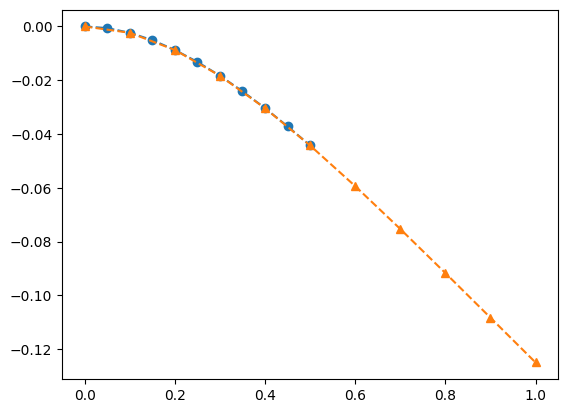

In [4]:
x_train = np.linspace(0, 0.5, num=11)[:, None].astype(np.float32)
x_train1 = np.linspace(0, 1, num=11)[:, None].astype(np.float32)
y_train_true = true_solution(x_train)
y_train1_true = true_solution(x_train1)

plt.plot(x_train, y_train_true, 'o--')
plt.plot(x_train1, y_train1_true, '^--')

In [5]:
# 1. Governing Equation Loss
def true_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

def compute_derivatives(x, model):
    with tf.GradientTape(persistent=True) as tape4:
        tape4.watch(x)
        with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(x)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(x)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(x)
                    # true_solution 함수를 호출하여 y 값을 설정
                    # y = true_solution(x)
                    y = model(x)
                    # y = y_pred
                dy_dx = tape1.gradient(y, x)
            d2y_dx2 = tape2.gradient(dy_dx, x)
        d3y_dx3 = tape3.gradient(d2y_dx2, x)
    d4y_dx4 = tape4.gradient(d3y_dx3, x)

    # del tape1, tape2, tape3, tape4  # 모든 tape를 삭제
    return y, dy_dx, d2y_dx2, d3y_dx3, d4y_dx4

def governing_equation_loss(d4y_dx4):
    f_x = d4y_dx4 + 1
    loss_ge = tf.reduce_mean(tf.square(f_x))
    return loss_ge

In [7]:
# Define a neural network model
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(20, activation='tanh', input_shape=(1,), kernel_initializer='he_normal'),
        tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(20, activation='tanh', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(1, kernel_initializer='he_normal')
    ])
    return model

In [8]:
# Create the model
model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
eps = 1e-6

# Training data
x_train = np.linspace(0, 1, num=11)[:, None].astype(np.float32)
x_train[0] = x_train[0] + eps
# print(x_train)

# x_boundary = np.array([[0.], [0.], [0.], [0.]], dtype=np.float32)
# x_boundary[0] = x_boundary[0] + eps
# x_boundary[1] = x_boundary[1] + eps
# x_boundary[2] = x_boundary[2] - eps
# x_boundary[3] = x_boundary[3] - eps

In [10]:
x_train_tensor = tf.convert_to_tensor(x_train[:], dtype=tf.float32)
# y, dy_dx, d2y_dx2, d3y_dx3, d4y_dx4
y_true, dy_dx_true, d2y_dx2_true, d3y_dx3_true, d4y_dx4_true = compute_derivatives(x_train_tensor, true_solution)
x_boundary_tensor = tf.convert_to_tensor(np.array([y_true[0], dy_dx_true[0], d2y_dx2_true[-1], d3y_dx3_true[-1]]), dtype=tf.float32)

Epoch   10| Total loss: 8780.609, Val loss: 0.016| L0: 0.023, L1: 8777.653, L2: 0.072, L3: 2.007, L4: 0.096, L5: 0.831
Epoch   20| Total loss: 7445.583, Val loss: 0.154| L0: 0.162, L1: 7444.646, L2: 0.146, L3: 0.279, L4: 0.076, L5: 0.421
Epoch   30| Total loss: 213.184, Val loss: 0.024| L0: 0.031, L1: 212.226, L2: 0.069, L3: 0.028, L4: 0.144, L5: 0.755
Epoch   40| Total loss: 763.579, Val loss: 0.008| L0: 0.008, L1: 762.204, L2: 0.036, L3: 0.278, L4: 0.146, L5: 0.943
Epoch   50| Total loss: 188.036, Val loss: 0.008| L0: 0.008, L1: 186.644, L2: 0.034, L3: 0.122, L4: 0.124, L5: 1.138
Epoch   60| Total loss: 119.536, Val loss: 0.008| L0: 0.008, L1: 118.182, L2: 0.032, L3: 0.052, L4: 0.095, L5: 1.199
Epoch   70| Total loss: 78.986, Val loss: 0.004| L0: 0.005, L1: 77.771, L2: 0.022, L3: 0.087, L4: 0.069, L5: 1.053
Epoch   80| Total loss: 57.850, Val loss: 0.004| L0: 0.004, L1: 56.805, L2: 0.014, L3: 0.133, L4: 0.054, L5: 0.854
Epoch   90| Total loss: 48.342, Val loss: 0.003| L0: 0.003, L1: 

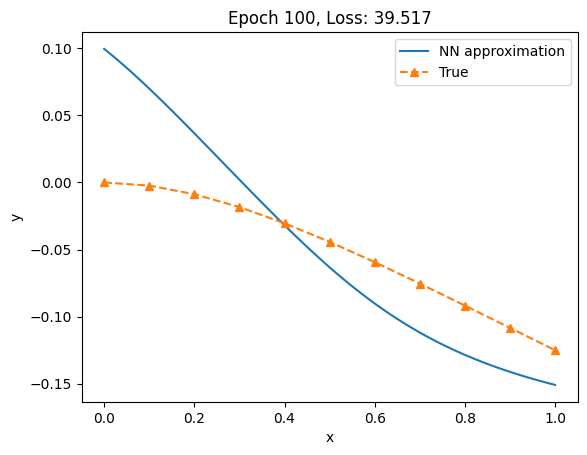

Epoch  110| Total loss: 35.203, Val loss: 0.002| L0: 0.002, L1: 34.601, L2: 0.009, L3: 0.060, L4: 0.036, L5: 0.504
Epoch  120| Total loss: 31.452, Val loss: 0.001| L0: 0.001, L1: 30.941, L2: 0.007, L3: 0.056, L4: 0.032, L5: 0.421
Epoch  130| Total loss: 28.769, Val loss: 0.001| L0: 0.001, L1: 28.330, L2: 0.006, L3: 0.050, L4: 0.029, L5: 0.358
Epoch  140| Total loss: 26.629, Val loss: 0.001| L0: 0.001, L1: 26.252, L2: 0.005, L3: 0.042, L4: 0.026, L5: 0.308
Epoch  150| Total loss: 24.859, Val loss: 0.001| L0: 0.001, L1: 24.533, L2: 0.004, L3: 0.037, L4: 0.024, L5: 0.265
Epoch  160| Total loss: 23.330, Val loss: 0.001| L0: 0.001, L1: 23.047, L2: 0.003, L3: 0.033, L4: 0.022, L5: 0.228
Epoch  170| Total loss: 21.963, Val loss: 0.001| L0: 0.001, L1: 21.716, L2: 0.003, L3: 0.028, L4: 0.020, L5: 0.198
Epoch  180| Total loss: 20.714, Val loss: 0.000| L0: 0.000, L1: 20.498, L2: 0.002, L3: 0.025, L4: 0.018, L5: 0.172
Epoch  190| Total loss: 19.553, Val loss: 0.000| L0: 0.000, L1: 19.363, L2: 0.00

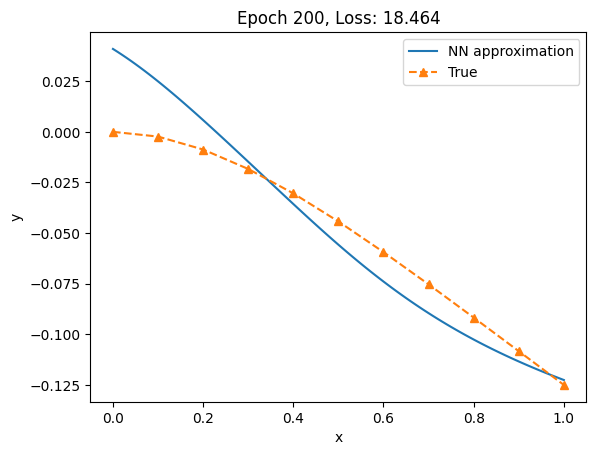

Epoch  210| Total loss: 17.439, Val loss: 0.000| L0: 0.000, L1: 17.292, L2: 0.001, L3: 0.017, L4: 0.015, L5: 0.114
Epoch  220| Total loss: 16.470, Val loss: 0.000| L0: 0.000, L1: 16.341, L2: 0.001, L3: 0.015, L4: 0.014, L5: 0.099
Epoch  230| Total loss: 15.554, Val loss: 0.000| L0: 0.000, L1: 15.441, L2: 0.001, L3: 0.013, L4: 0.013, L5: 0.086
Epoch  240| Total loss: 14.688, Val loss: 0.000| L0: 0.000, L1: 14.589, L2: 0.001, L3: 0.012, L4: 0.013, L5: 0.075
Epoch  250| Total loss: 13.869, Val loss: 0.000| L0: 0.000, L1: 13.783, L2: 0.001, L3: 0.010, L4: 0.012, L5: 0.064
Epoch  260| Total loss: 13.096, Val loss: 0.000| L0: 0.000, L1: 13.020, L2: 0.001, L3: 0.009, L4: 0.011, L5: 0.055
Epoch  270| Total loss: 12.365, Val loss: 0.000| L0: 0.000, L1: 12.299, L2: 0.000, L3: 0.008, L4: 0.011, L5: 0.047
Epoch  280| Total loss: 11.674, Val loss: 0.000| L0: 0.000, L1: 11.618, L2: 0.000, L3: 0.007, L4: 0.010, L5: 0.039
Epoch  290| Total loss: 11.022, Val loss: 0.000| L0: 0.000, L1: 10.974, L2: 0.00

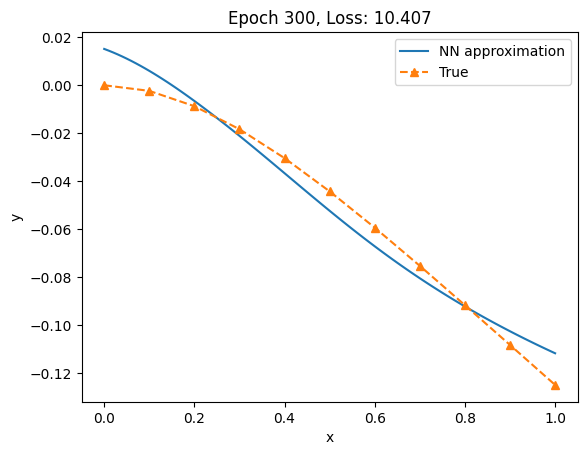

Epoch  310| Total loss: 9.827, Val loss: 0.000| L0: 0.000, L1: 9.791, L2: 0.000, L3: 0.004, L4: 0.009, L5: 0.022
Epoch  320| Total loss: 9.279, Val loss: 0.000| L0: 0.000, L1: 9.248, L2: 0.000, L3: 0.004, L4: 0.009, L5: 0.018
Epoch  330| Total loss: 8.762, Val loss: 0.000| L0: 0.000, L1: 8.736, L2: 0.000, L3: 0.003, L4: 0.008, L5: 0.014
Epoch  340| Total loss: 8.274, Val loss: 0.000| L0: 0.000, L1: 8.252, L2: 0.000, L3: 0.002, L4: 0.008, L5: 0.011
Epoch  350| Total loss: 7.814, Val loss: 0.000| L0: 0.000, L1: 7.795, L2: 0.000, L3: 0.002, L4: 0.008, L5: 0.008
Epoch  360| Total loss: 7.380, Val loss: 0.000| L0: 0.000, L1: 7.364, L2: 0.000, L3: 0.002, L4: 0.008, L5: 0.006
Epoch  370| Total loss: 6.970, Val loss: 0.000| L0: 0.000, L1: 6.957, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch  380| Total loss: 6.583, Val loss: 0.000| L0: 0.000, L1: 6.572, L2: 0.000, L3: 0.001, L4: 0.007, L5: 0.003
Epoch  390| Total loss: 6.219, Val loss: 0.000| L0: 0.000, L1: 6.209, L2: 0.000, L3: 0.001, L4: 

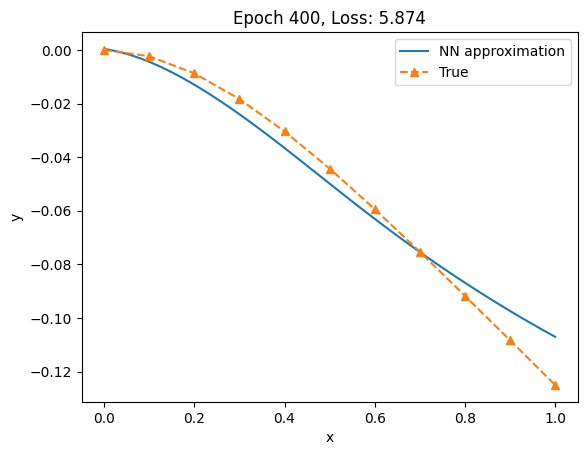

Epoch  410| Total loss: 5.549, Val loss: 0.000| L0: 0.000, L1: 5.541, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.000
Epoch  420| Total loss: 5.243, Val loss: 0.000| L0: 0.000, L1: 5.235, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.000
Epoch  430| Total loss: 4.953, Val loss: 0.000| L0: 0.000, L1: 4.946, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.000
Epoch  440| Total loss: 4.680, Val loss: 0.000| L0: 0.000, L1: 4.673, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.000
Epoch  450| Total loss: 4.422, Val loss: 0.000| L0: 0.000, L1: 4.414, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.000
Epoch  460| Total loss: 4.178, Val loss: 0.000| L0: 0.000, L1: 4.171, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.001
Epoch  470| Total loss: 3.948, Val loss: 0.000| L0: 0.000, L1: 3.940, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.001
Epoch  480| Total loss: 3.731, Val loss: 0.000| L0: 0.000, L1: 3.722, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.002
Epoch  490| Total loss: 3.526, Val loss: 0.000| L0: 0.000, L1: 3.517, L2: 0.000, L3: 0.000, L4: 

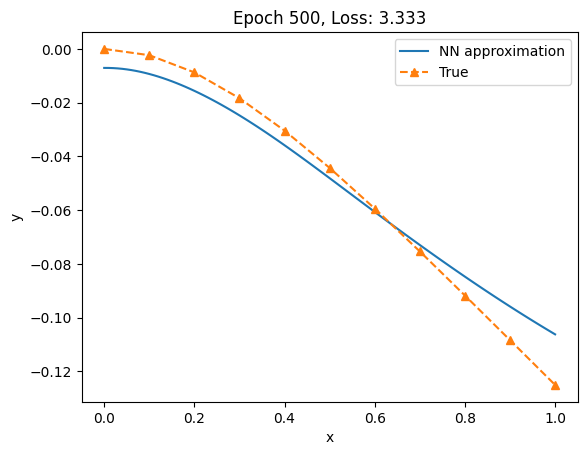

Epoch  510| Total loss: 3.150, Val loss: 0.000| L0: 0.000, L1: 3.139, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.004
Epoch  520| Total loss: 2.977, Val loss: 0.000| L0: 0.000, L1: 2.965, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.005
Epoch  530| Total loss: 2.814, Val loss: 0.000| L0: 0.000, L1: 2.801, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.006
Epoch  540| Total loss: 2.660, Val loss: 0.000| L0: 0.000, L1: 2.646, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.007
Epoch  550| Total loss: 2.515, Val loss: 0.000| L0: 0.000, L1: 2.500, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.008
Epoch  560| Total loss: 2.378, Val loss: 0.000| L0: 0.000, L1: 2.361, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.009
Epoch  570| Total loss: 2.248, Val loss: 0.000| L0: 0.000, L1: 2.230, L2: 0.000, L3: 0.000, L4: 0.007, L5: 0.010
Epoch  580| Total loss: 2.126, Val loss: 0.000| L0: 0.000, L1: 2.107, L2: 0.000, L3: 0.000, L4: 0.008, L5: 0.011
Epoch  590| Total loss: 2.010, Val loss: 0.000| L0: 0.000, L1: 1.990, L2: 0.000, L3: 0.000, L4: 

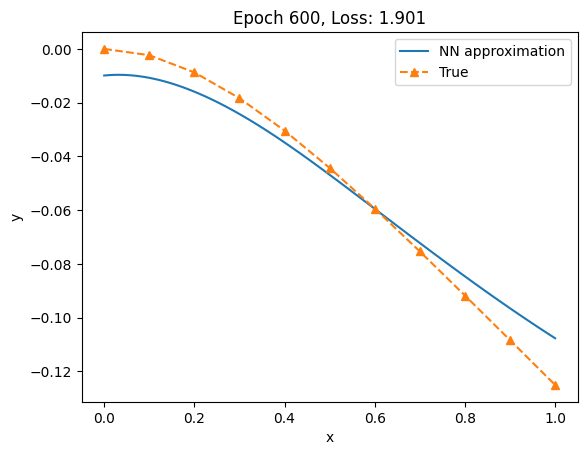

Epoch  610| Total loss: 1.798, Val loss: 0.000| L0: 0.000, L1: 1.776, L2: 0.000, L3: 0.000, L4: 0.008, L5: 0.014
Epoch  620| Total loss: 1.701, Val loss: 0.000| L0: 0.000, L1: 1.678, L2: 0.000, L3: 0.000, L4: 0.008, L5: 0.015
Epoch  630| Total loss: 1.609, Val loss: 0.000| L0: 0.000, L1: 1.585, L2: 0.000, L3: 0.000, L4: 0.008, L5: 0.016
Epoch  640| Total loss: 1.522, Val loss: 0.000| L0: 0.000, L1: 1.497, L2: 0.000, L3: 0.000, L4: 0.008, L5: 0.016
Epoch  650| Total loss: 1.441, Val loss: 0.000| L0: 0.000, L1: 1.414, L2: 0.000, L3: 0.000, L4: 0.008, L5: 0.017
Epoch  660| Total loss: 1.364, Val loss: 0.000| L0: 0.000, L1: 1.336, L2: 0.000, L3: 0.000, L4: 0.009, L5: 0.018
Epoch  670| Total loss: 1.291, Val loss: 0.000| L0: 0.000, L1: 1.263, L2: 0.000, L3: 0.001, L4: 0.009, L5: 0.019
Epoch  680| Total loss: 1.222, Val loss: 0.000| L0: 0.000, L1: 1.193, L2: 0.000, L3: 0.001, L4: 0.009, L5: 0.020
Epoch  690| Total loss: 1.158, Val loss: 0.000| L0: 0.000, L1: 1.127, L2: 0.000, L3: 0.001, L4: 

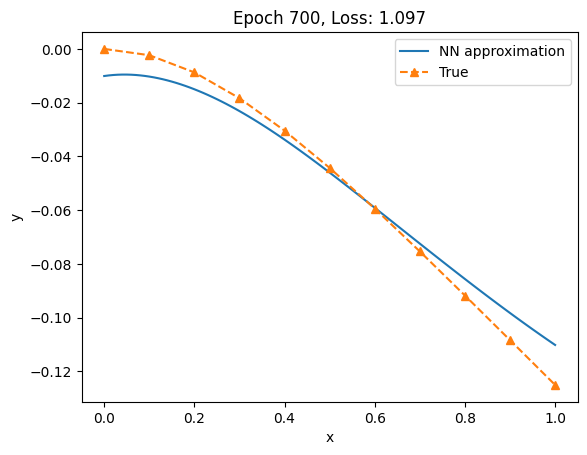

Epoch  710| Total loss: 1.039, Val loss: 0.000| L0: 0.000, L1: 1.007, L2: 0.000, L3: 0.001, L4: 0.009, L5: 0.022
Epoch  720| Total loss: 0.985, Val loss: 0.000| L0: 0.000, L1: 0.952, L2: 0.000, L3: 0.001, L4: 0.010, L5: 0.023
Epoch  730| Total loss: 0.934, Val loss: 0.000| L0: 0.000, L1: 0.900, L2: 0.000, L3: 0.001, L4: 0.010, L5: 0.023
Epoch  740| Total loss: 0.885, Val loss: 0.000| L0: 0.000, L1: 0.851, L2: 0.000, L3: 0.001, L4: 0.010, L5: 0.024
Epoch  750| Total loss: 0.840, Val loss: 0.000| L0: 0.000, L1: 0.805, L2: 0.000, L3: 0.001, L4: 0.010, L5: 0.024
Epoch  760| Total loss: 0.797, Val loss: 0.000| L0: 0.000, L1: 0.761, L2: 0.000, L3: 0.001, L4: 0.010, L5: 0.025
Epoch  770| Total loss: 0.757, Val loss: 0.000| L0: 0.000, L1: 0.720, L2: 0.000, L3: 0.001, L4: 0.010, L5: 0.025
Epoch  780| Total loss: 0.719, Val loss: 0.000| L0: 0.000, L1: 0.682, L2: 0.000, L3: 0.001, L4: 0.011, L5: 0.026
Epoch  790| Total loss: 0.683, Val loss: 0.000| L0: 0.000, L1: 0.645, L2: 0.000, L3: 0.001, L4: 

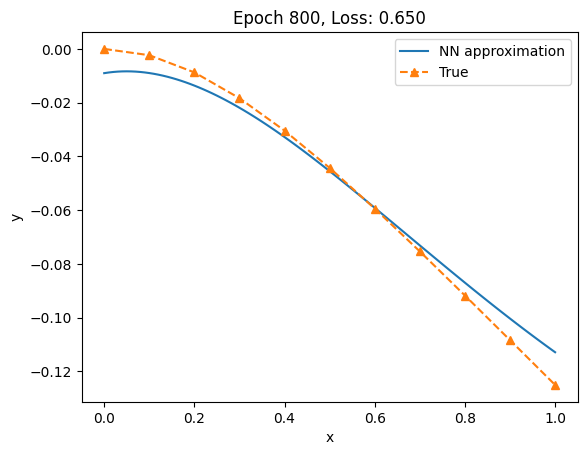

Epoch  810| Total loss: 0.618, Val loss: 0.000| L0: 0.000, L1: 0.579, L2: 0.000, L3: 0.001, L4: 0.011, L5: 0.027
Epoch  820| Total loss: 0.588, Val loss: 0.000| L0: 0.000, L1: 0.549, L2: 0.000, L3: 0.001, L4: 0.011, L5: 0.027
Epoch  830| Total loss: 0.560, Val loss: 0.000| L0: 0.000, L1: 0.520, L2: 0.000, L3: 0.001, L4: 0.012, L5: 0.028
Epoch  840| Total loss: 0.534, Val loss: 0.000| L0: 0.000, L1: 0.493, L2: 0.000, L3: 0.001, L4: 0.012, L5: 0.028
Epoch  850| Total loss: 0.509, Val loss: 0.000| L0: 0.000, L1: 0.468, L2: 0.000, L3: 0.001, L4: 0.012, L5: 0.028
Epoch  860| Total loss: 0.486, Val loss: 0.000| L0: 0.000, L1: 0.444, L2: 0.000, L3: 0.001, L4: 0.012, L5: 0.029
Epoch  870| Total loss: 0.464, Val loss: 0.000| L0: 0.000, L1: 0.422, L2: 0.000, L3: 0.001, L4: 0.012, L5: 0.029
Epoch  880| Total loss: 0.443, Val loss: 0.000| L0: 0.000, L1: 0.401, L2: 0.000, L3: 0.001, L4: 0.012, L5: 0.029
Epoch  890| Total loss: 0.424, Val loss: 0.000| L0: 0.000, L1: 0.381, L2: 0.000, L3: 0.001, L4: 

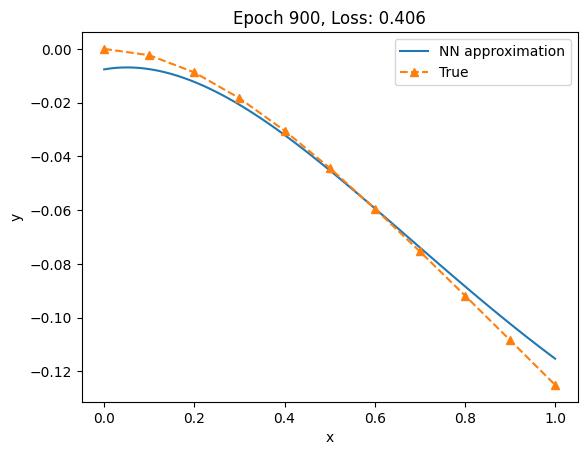

Epoch  910| Total loss: 0.389, Val loss: 0.000| L0: 0.000, L1: 0.346, L2: 0.000, L3: 0.001, L4: 0.013, L5: 0.030
Epoch  920| Total loss: 0.373, Val loss: 0.000| L0: 0.000, L1: 0.329, L2: 0.000, L3: 0.001, L4: 0.013, L5: 0.030
Epoch  930| Total loss: 0.358, Val loss: 0.000| L0: 0.000, L1: 0.314, L2: 0.000, L3: 0.001, L4: 0.013, L5: 0.030
Epoch  940| Total loss: 0.344, Val loss: 0.000| L0: 0.000, L1: 0.300, L2: 0.000, L3: 0.001, L4: 0.013, L5: 0.030
Epoch  950| Total loss: 0.331, Val loss: 0.000| L0: 0.000, L1: 0.286, L2: 0.000, L3: 0.001, L4: 0.014, L5: 0.030
Epoch  960| Total loss: 0.319, Val loss: 0.000| L0: 0.000, L1: 0.274, L2: 0.000, L3: 0.001, L4: 0.014, L5: 0.030
Epoch  970| Total loss: 0.307, Val loss: 0.000| L0: 0.000, L1: 0.262, L2: 0.000, L3: 0.001, L4: 0.014, L5: 0.030
Epoch  980| Total loss: 0.296, Val loss: 0.000| L0: 0.000, L1: 0.251, L2: 0.000, L3: 0.001, L4: 0.014, L5: 0.030
Epoch  990| Total loss: 0.286, Val loss: 0.000| L0: 0.000, L1: 0.241, L2: 0.000, L3: 0.001, L4: 

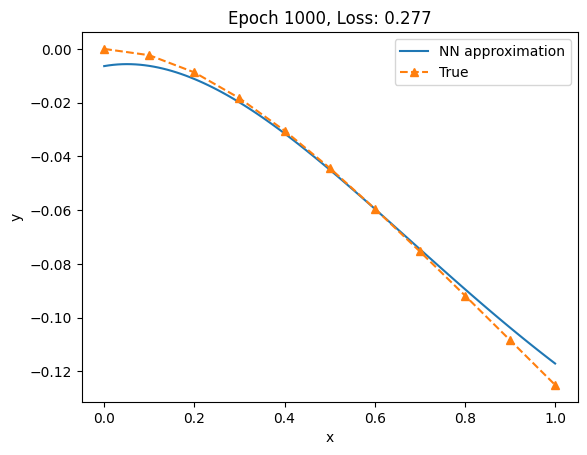

Epoch 1010| Total loss: 0.268, Val loss: 0.000| L0: 0.000, L1: 0.222, L2: 0.000, L3: 0.001, L4: 0.014, L5: 0.031
Epoch 1020| Total loss: 0.259, Val loss: 0.000| L0: 0.000, L1: 0.213, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1030| Total loss: 0.251, Val loss: 0.000| L0: 0.000, L1: 0.205, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1040| Total loss: 0.244, Val loss: 0.000| L0: 0.000, L1: 0.198, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1050| Total loss: 0.237, Val loss: 0.000| L0: 0.000, L1: 0.191, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1060| Total loss: 0.231, Val loss: 0.000| L0: 0.000, L1: 0.184, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1070| Total loss: 0.225, Val loss: 0.000| L0: 0.000, L1: 0.178, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1080| Total loss: 0.219, Val loss: 0.000| L0: 0.000, L1: 0.172, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1090| Total loss: 0.214, Val loss: 0.000| L0: 0.000, L1: 0.167, L2: 0.000, L3: 0.001, L4: 

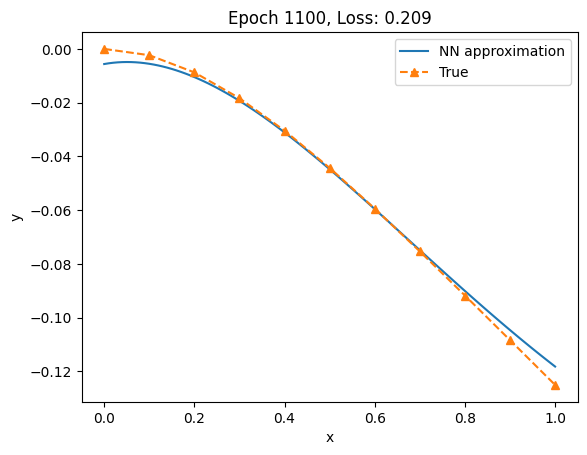

Epoch 1110| Total loss: 0.204, Val loss: 0.000| L0: 0.000, L1: 0.157, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.031
Epoch 1120| Total loss: 0.200, Val loss: 0.000| L0: 0.000, L1: 0.153, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.031
Epoch 1130| Total loss: 0.196, Val loss: 0.000| L0: 0.000, L1: 0.148, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.031
Epoch 1140| Total loss: 0.192, Val loss: 0.000| L0: 0.000, L1: 0.144, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.031
Epoch 1150| Total loss: 0.188, Val loss: 0.000| L0: 0.000, L1: 0.141, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.031
Epoch 1160| Total loss: 0.185, Val loss: 0.000| L0: 0.000, L1: 0.137, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.031
Epoch 1170| Total loss: 0.181, Val loss: 0.000| L0: 0.000, L1: 0.134, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1180| Total loss: 0.178, Val loss: 0.000| L0: 0.000, L1: 0.131, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1190| Total loss: 0.175, Val loss: 0.000| L0: 0.000, L1: 0.128, L2: 0.000, L3: 0.001, L4: 

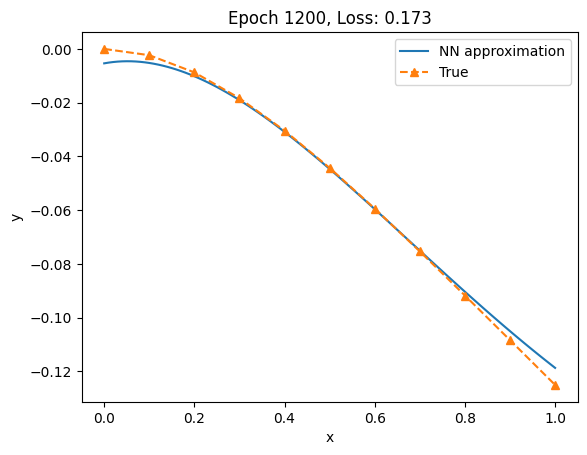

Epoch 1210| Total loss: 0.170, Val loss: 0.000| L0: 0.000, L1: 0.123, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1220| Total loss: 0.168, Val loss: 0.000| L0: 0.000, L1: 0.120, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1230| Total loss: 0.165, Val loss: 0.000| L0: 0.000, L1: 0.118, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1240| Total loss: 0.163, Val loss: 0.000| L0: 0.000, L1: 0.116, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1250| Total loss: 0.161, Val loss: 0.000| L0: 0.000, L1: 0.114, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1260| Total loss: 0.159, Val loss: 0.000| L0: 0.000, L1: 0.112, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1270| Total loss: 0.157, Val loss: 0.000| L0: 0.000, L1: 0.110, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1280| Total loss: 0.156, Val loss: 0.000| L0: 0.000, L1: 0.108, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1290| Total loss: 0.154, Val loss: 0.000| L0: 0.000, L1: 0.107, L2: 0.000, L3: 0.001, L4: 

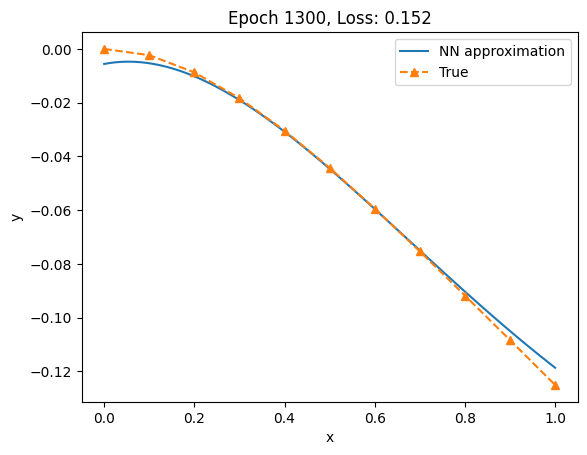

Epoch 1310| Total loss: 0.151, Val loss: 0.000| L0: 0.000, L1: 0.104, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1320| Total loss: 0.149, Val loss: 0.000| L0: 0.000, L1: 0.102, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1330| Total loss: 0.148, Val loss: 0.000| L0: 0.000, L1: 0.101, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1340| Total loss: 0.146, Val loss: 0.000| L0: 0.000, L1: 0.099, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1350| Total loss: 0.145, Val loss: 0.000| L0: 0.000, L1: 0.098, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1360| Total loss: 0.144, Val loss: 0.000| L0: 0.000, L1: 0.097, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1370| Total loss: 0.142, Val loss: 0.000| L0: 0.000, L1: 0.096, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1380| Total loss: 0.141, Val loss: 0.000| L0: 0.000, L1: 0.094, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.030
Epoch 1390| Total loss: 0.140, Val loss: 0.000| L0: 0.000, L1: 0.093, L2: 0.000, L3: 0.001, L4: 

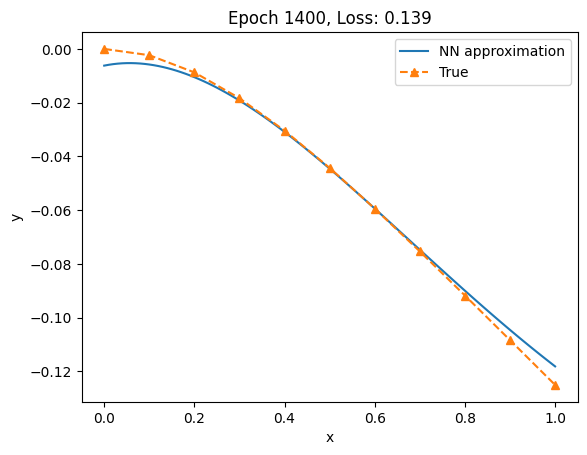

Epoch 1410| Total loss: 0.138, Val loss: 0.000| L0: 0.000, L1: 0.091, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1420| Total loss: 0.137, Val loss: 0.000| L0: 0.000, L1: 0.090, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1430| Total loss: 0.136, Val loss: 0.000| L0: 0.000, L1: 0.089, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1440| Total loss: 0.135, Val loss: 0.000| L0: 0.000, L1: 0.088, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1450| Total loss: 0.134, Val loss: 0.000| L0: 0.000, L1: 0.087, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1460| Total loss: 0.133, Val loss: 0.000| L0: 0.000, L1: 0.086, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1470| Total loss: 0.132, Val loss: 0.000| L0: 0.000, L1: 0.085, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1480| Total loss: 0.131, Val loss: 0.000| L0: 0.000, L1: 0.084, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1490| Total loss: 0.130, Val loss: 0.000| L0: 0.000, L1: 0.083, L2: 0.000, L3: 0.001, L4: 

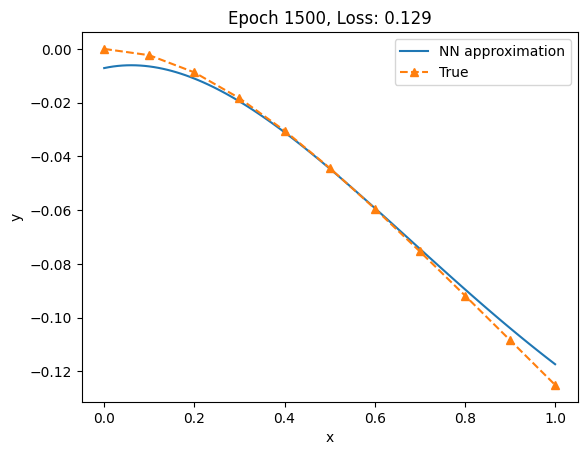

Epoch 1510| Total loss: 0.128, Val loss: 0.000| L0: 0.000, L1: 0.082, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1520| Total loss: 0.127, Val loss: 0.000| L0: 0.000, L1: 0.081, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1530| Total loss: 0.126, Val loss: 0.000| L0: 0.000, L1: 0.080, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1540| Total loss: 0.125, Val loss: 0.000| L0: 0.000, L1: 0.079, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1550| Total loss: 0.124, Val loss: 0.000| L0: 0.000, L1: 0.078, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1560| Total loss: 0.123, Val loss: 0.000| L0: 0.000, L1: 0.078, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1570| Total loss: 0.123, Val loss: 0.000| L0: 0.000, L1: 0.077, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1580| Total loss: 0.122, Val loss: 0.000| L0: 0.000, L1: 0.076, L2: 0.000, L3: 0.001, L4: 0.016, L5: 0.029
Epoch 1590| Total loss: 0.121, Val loss: 0.000| L0: 0.000, L1: 0.075, L2: 0.000, L3: 0.001, L4: 

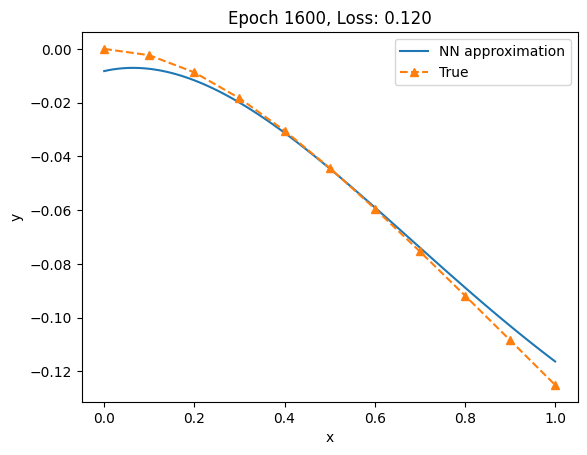

Epoch 1610| Total loss: 0.119, Val loss: 0.000| L0: 0.000, L1: 0.074, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.028
Epoch 1620| Total loss: 0.118, Val loss: 0.000| L0: 0.000, L1: 0.073, L2: 0.000, L3: 0.001, L4: 0.015, L5: 0.028
Epoch 1630| Total loss: 0.117, Val loss: 0.000| L0: 0.000, L1: 0.072, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1640| Total loss: 0.117, Val loss: 0.000| L0: 0.000, L1: 0.072, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1650| Total loss: 0.116, Val loss: 0.000| L0: 0.000, L1: 0.071, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1660| Total loss: 0.115, Val loss: 0.000| L0: 0.000, L1: 0.070, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1670| Total loss: 0.114, Val loss: 0.000| L0: 0.000, L1: 0.069, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1680| Total loss: 0.113, Val loss: 0.000| L0: 0.000, L1: 0.069, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1690| Total loss: 0.113, Val loss: 0.000| L0: 0.000, L1: 0.068, L2: 0.000, L3: 0.002, L4: 

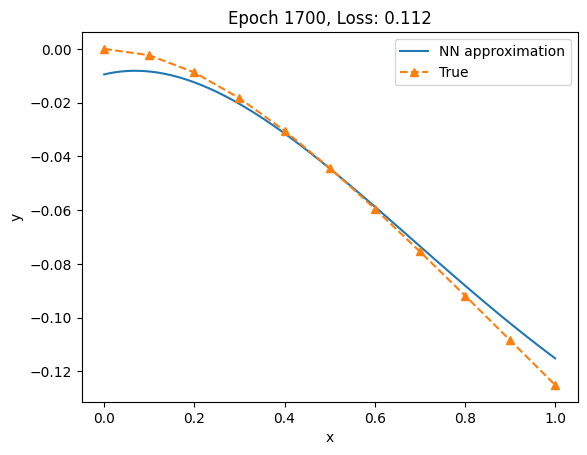

Epoch 1710| Total loss: 0.111, Val loss: 0.000| L0: 0.000, L1: 0.067, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1720| Total loss: 0.110, Val loss: 0.000| L0: 0.000, L1: 0.066, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1730| Total loss: 0.110, Val loss: 0.000| L0: 0.000, L1: 0.065, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1740| Total loss: 0.109, Val loss: 0.000| L0: 0.000, L1: 0.065, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1750| Total loss: 0.108, Val loss: 0.000| L0: 0.000, L1: 0.064, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1760| Total loss: 0.107, Val loss: 0.000| L0: 0.000, L1: 0.063, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1770| Total loss: 0.107, Val loss: 0.000| L0: 0.000, L1: 0.063, L2: 0.000, L3: 0.002, L4: 0.015, L5: 0.028
Epoch 1780| Total loss: 0.106, Val loss: 0.000| L0: 0.000, L1: 0.062, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.028
Epoch 1790| Total loss: 0.105, Val loss: 0.000| L0: 0.000, L1: 0.061, L2: 0.000, L3: 0.002, L4: 

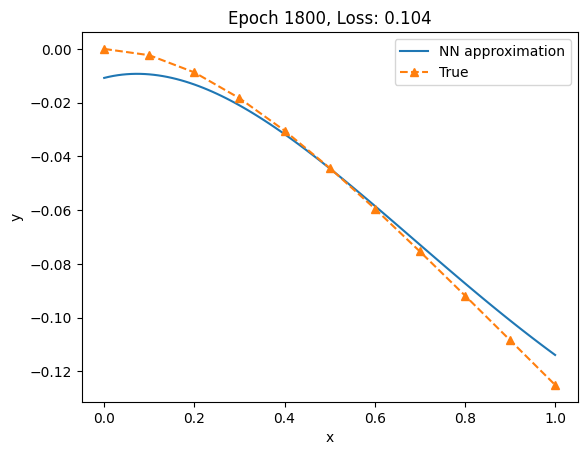

Epoch 1810| Total loss: 0.104, Val loss: 0.000| L0: 0.000, L1: 0.060, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1820| Total loss: 0.103, Val loss: 0.000| L0: 0.000, L1: 0.059, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1830| Total loss: 0.102, Val loss: 0.000| L0: 0.000, L1: 0.059, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1840| Total loss: 0.101, Val loss: 0.000| L0: 0.000, L1: 0.058, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1850| Total loss: 0.101, Val loss: 0.000| L0: 0.000, L1: 0.057, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1860| Total loss: 0.100, Val loss: 0.000| L0: 0.000, L1: 0.057, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1870| Total loss: 0.099, Val loss: 0.000| L0: 0.000, L1: 0.056, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1880| Total loss: 0.099, Val loss: 0.000| L0: 0.000, L1: 0.056, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1890| Total loss: 0.098, Val loss: 0.000| L0: 0.000, L1: 0.055, L2: 0.000, L3: 0.002, L4: 

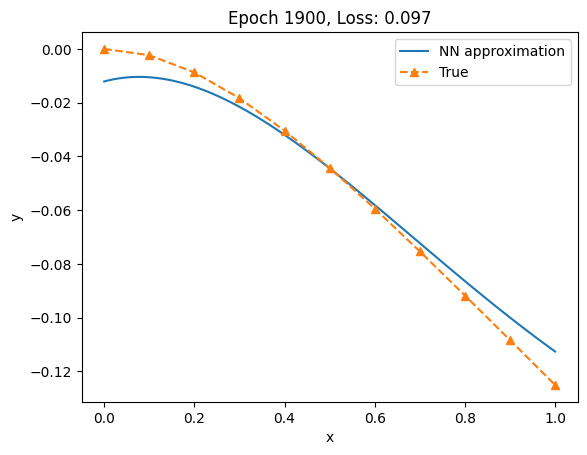

Epoch 1910| Total loss: 0.096, Val loss: 0.000| L0: 0.000, L1: 0.054, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1920| Total loss: 0.096, Val loss: 0.000| L0: 0.000, L1: 0.053, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1930| Total loss: 0.095, Val loss: 0.000| L0: 0.000, L1: 0.053, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1940| Total loss: 0.094, Val loss: 0.000| L0: 0.000, L1: 0.052, L2: 0.000, L3: 0.002, L4: 0.014, L5: 0.027
Epoch 1950| Total loss: 0.094, Val loss: 0.000| L0: 0.000, L1: 0.051, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.027
Epoch 1960| Total loss: 0.093, Val loss: 0.000| L0: 0.000, L1: 0.051, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.027
Epoch 1970| Total loss: 0.092, Val loss: 0.000| L0: 0.000, L1: 0.050, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 1980| Total loss: 0.092, Val loss: 0.000| L0: 0.000, L1: 0.050, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 1990| Total loss: 0.091, Val loss: 0.000| L0: 0.000, L1: 0.049, L2: 0.000, L3: 0.002, L4: 

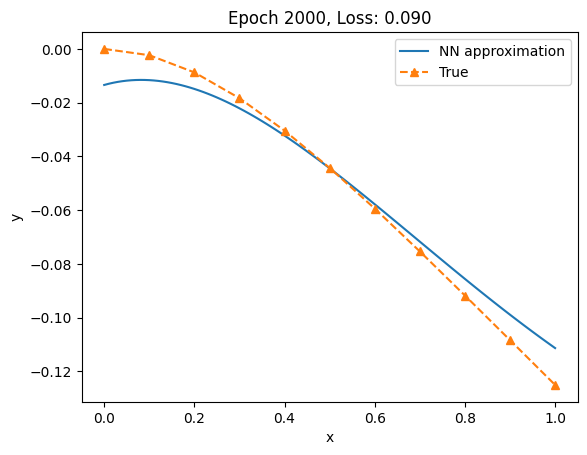

Epoch 2010| Total loss: 0.090, Val loss: 0.000| L0: 0.000, L1: 0.048, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2020| Total loss: 0.089, Val loss: 0.000| L0: 0.000, L1: 0.047, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2030| Total loss: 0.088, Val loss: 0.000| L0: 0.000, L1: 0.047, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2040| Total loss: 0.088, Val loss: 0.000| L0: 0.000, L1: 0.046, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2050| Total loss: 0.087, Val loss: 0.000| L0: 0.000, L1: 0.046, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2060| Total loss: 0.087, Val loss: 0.000| L0: 0.000, L1: 0.045, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2070| Total loss: 0.086, Val loss: 0.000| L0: 0.000, L1: 0.045, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2080| Total loss: 0.085, Val loss: 0.000| L0: 0.000, L1: 0.044, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2090| Total loss: 0.085, Val loss: 0.000| L0: 0.000, L1: 0.044, L2: 0.000, L3: 0.002, L4: 

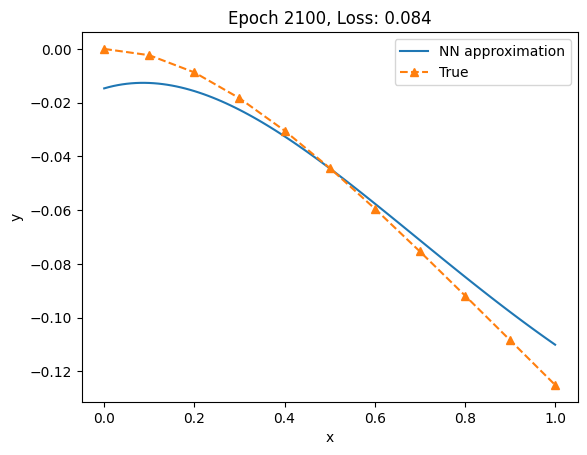

Epoch 2110| Total loss: 0.083, Val loss: 0.000| L0: 0.000, L1: 0.043, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2120| Total loss: 0.083, Val loss: 0.000| L0: 0.000, L1: 0.042, L2: 0.000, L3: 0.002, L4: 0.013, L5: 0.026
Epoch 2130| Total loss: 0.082, Val loss: 0.000| L0: 0.000, L1: 0.042, L2: 0.000, L3: 0.002, L4: 0.012, L5: 0.025
Epoch 2140| Total loss: 0.082, Val loss: 0.000| L0: 0.000, L1: 0.041, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2150| Total loss: 0.081, Val loss: 0.000| L0: 0.000, L1: 0.041, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2160| Total loss: 0.080, Val loss: 0.000| L0: 0.000, L1: 0.040, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2170| Total loss: 0.080, Val loss: 0.000| L0: 0.000, L1: 0.040, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2180| Total loss: 0.079, Val loss: 0.000| L0: 0.000, L1: 0.039, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2190| Total loss: 0.079, Val loss: 0.000| L0: 0.000, L1: 0.039, L2: 0.000, L3: 0.003, L4: 

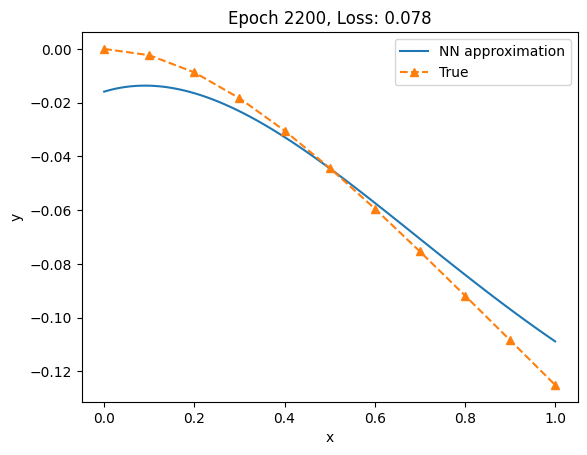

Epoch 2210| Total loss: 0.078, Val loss: 0.000| L0: 0.000, L1: 0.038, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2220| Total loss: 0.077, Val loss: 0.000| L0: 0.000, L1: 0.037, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2230| Total loss: 0.076, Val loss: 0.000| L0: 0.000, L1: 0.037, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2240| Total loss: 0.076, Val loss: 0.000| L0: 0.000, L1: 0.036, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2250| Total loss: 0.075, Val loss: 0.000| L0: 0.000, L1: 0.036, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2260| Total loss: 0.075, Val loss: 0.000| L0: 0.000, L1: 0.036, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2270| Total loss: 0.074, Val loss: 0.000| L0: 0.000, L1: 0.035, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2280| Total loss: 0.074, Val loss: 0.000| L0: 0.000, L1: 0.035, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.025
Epoch 2290| Total loss: 0.073, Val loss: 0.000| L0: 0.000, L1: 0.034, L2: 0.000, L3: 0.003, L4: 

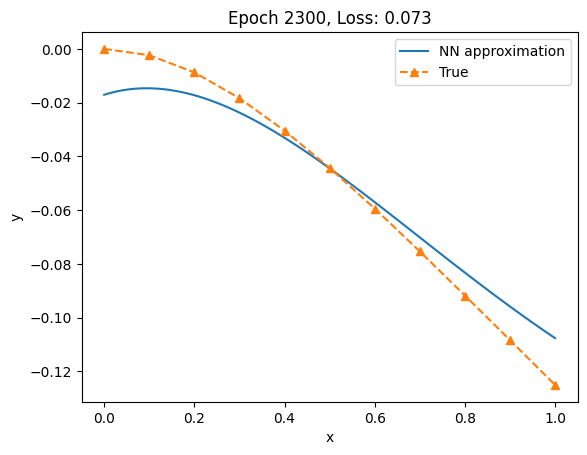

Epoch 2310| Total loss: 0.072, Val loss: 0.000| L0: 0.000, L1: 0.033, L2: 0.000, L3: 0.003, L4: 0.012, L5: 0.024
Epoch 2320| Total loss: 0.072, Val loss: 0.000| L0: 0.000, L1: 0.033, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2330| Total loss: 0.071, Val loss: 0.000| L0: 0.000, L1: 0.033, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2340| Total loss: 0.071, Val loss: 0.000| L0: 0.000, L1: 0.032, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2350| Total loss: 0.070, Val loss: 0.000| L0: 0.000, L1: 0.032, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2360| Total loss: 0.070, Val loss: 0.000| L0: 0.000, L1: 0.031, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2370| Total loss: 0.069, Val loss: 0.000| L0: 0.000, L1: 0.031, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2380| Total loss: 0.069, Val loss: 0.000| L0: 0.000, L1: 0.031, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2390| Total loss: 0.068, Val loss: 0.000| L0: 0.000, L1: 0.030, L2: 0.000, L3: 0.003, L4: 

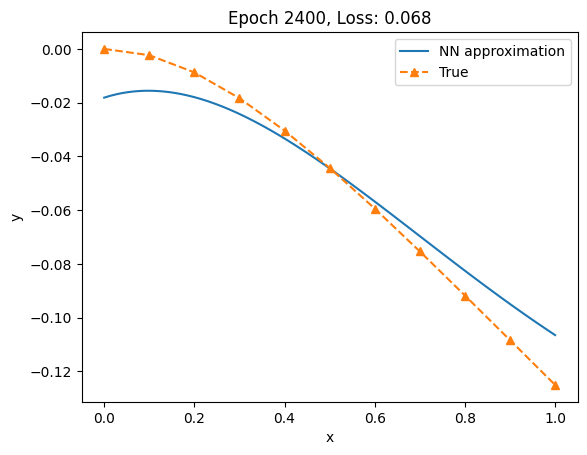

Epoch 2410| Total loss: 0.067, Val loss: 0.000| L0: 0.000, L1: 0.029, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2420| Total loss: 0.067, Val loss: 0.000| L0: 0.000, L1: 0.029, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.024
Epoch 2430| Total loss: 0.066, Val loss: 0.000| L0: 0.000, L1: 0.029, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2440| Total loss: 0.066, Val loss: 0.000| L0: 0.000, L1: 0.028, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2450| Total loss: 0.065, Val loss: 0.000| L0: 0.000, L1: 0.028, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2460| Total loss: 0.065, Val loss: 0.000| L0: 0.000, L1: 0.027, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2470| Total loss: 0.064, Val loss: 0.000| L0: 0.000, L1: 0.027, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2480| Total loss: 0.064, Val loss: 0.000| L0: 0.000, L1: 0.027, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2490| Total loss: 0.063, Val loss: 0.000| L0: 0.000, L1: 0.026, L2: 0.000, L3: 0.003, L4: 

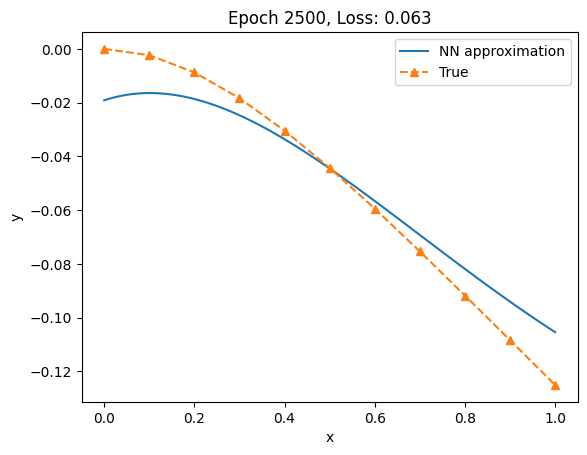

Epoch 2510| Total loss: 0.062, Val loss: 0.000| L0: 0.000, L1: 0.026, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2520| Total loss: 0.062, Val loss: 0.000| L0: 0.000, L1: 0.025, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2530| Total loss: 0.062, Val loss: 0.000| L0: 0.000, L1: 0.025, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2540| Total loss: 0.061, Val loss: 0.000| L0: 0.000, L1: 0.025, L2: 0.000, L3: 0.003, L4: 0.011, L5: 0.023
Epoch 2550| Total loss: 0.061, Val loss: 0.000| L0: 0.000, L1: 0.024, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.023
Epoch 2560| Total loss: 0.060, Val loss: 0.000| L0: 0.000, L1: 0.024, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2570| Total loss: 0.060, Val loss: 0.000| L0: 0.000, L1: 0.024, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2580| Total loss: 0.059, Val loss: 0.000| L0: 0.000, L1: 0.023, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2590| Total loss: 0.059, Val loss: 0.000| L0: 0.000, L1: 0.023, L2: 0.000, L3: 0.003, L4: 

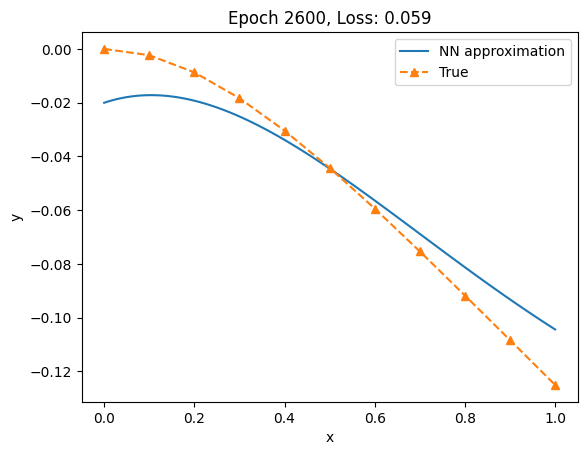

Epoch 2610| Total loss: 0.058, Val loss: 0.000| L0: 0.000, L1: 0.023, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2620| Total loss: 0.058, Val loss: 0.000| L0: 0.000, L1: 0.022, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2630| Total loss: 0.057, Val loss: 0.000| L0: 0.000, L1: 0.022, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2640| Total loss: 0.057, Val loss: 0.000| L0: 0.000, L1: 0.022, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2650| Total loss: 0.057, Val loss: 0.000| L0: 0.000, L1: 0.021, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2660| Total loss: 0.056, Val loss: 0.000| L0: 0.000, L1: 0.021, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2670| Total loss: 0.056, Val loss: 0.000| L0: 0.000, L1: 0.021, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2680| Total loss: 0.055, Val loss: 0.000| L0: 0.000, L1: 0.020, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.022
Epoch 2690| Total loss: 0.055, Val loss: 0.000| L0: 0.000, L1: 0.020, L2: 0.000, L3: 0.003, L4: 

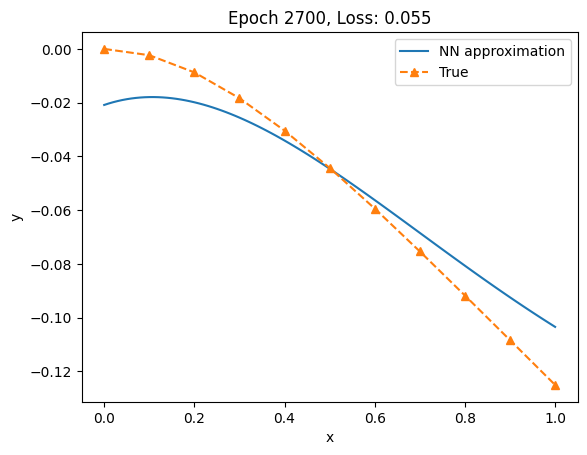

Epoch 2710| Total loss: 0.054, Val loss: 0.000| L0: 0.000, L1: 0.020, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2720| Total loss: 0.054, Val loss: 0.000| L0: 0.000, L1: 0.019, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2730| Total loss: 0.054, Val loss: 0.000| L0: 0.000, L1: 0.019, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2740| Total loss: 0.053, Val loss: 0.000| L0: 0.000, L1: 0.019, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2750| Total loss: 0.053, Val loss: 0.000| L0: 0.000, L1: 0.019, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2760| Total loss: 0.053, Val loss: 0.000| L0: 0.000, L1: 0.018, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2770| Total loss: 0.052, Val loss: 0.000| L0: 0.000, L1: 0.018, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2780| Total loss: 0.052, Val loss: 0.000| L0: 0.000, L1: 0.018, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.021
Epoch 2790| Total loss: 0.051, Val loss: 0.000| L0: 0.000, L1: 0.018, L2: 0.000, L3: 0.003, L4: 

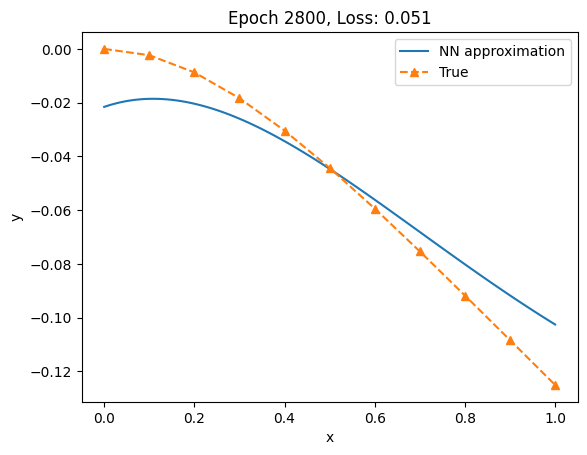

Epoch 2810| Total loss: 0.051, Val loss: 0.000| L0: 0.000, L1: 0.017, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.020
Epoch 2820| Total loss: 0.050, Val loss: 0.000| L0: 0.000, L1: 0.017, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.020
Epoch 2830| Total loss: 0.050, Val loss: 0.000| L0: 0.000, L1: 0.017, L2: 0.000, L3: 0.003, L4: 0.010, L5: 0.020
Epoch 2840| Total loss: 0.050, Val loss: 0.000| L0: 0.000, L1: 0.017, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2850| Total loss: 0.049, Val loss: 0.000| L0: 0.000, L1: 0.016, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2860| Total loss: 0.049, Val loss: 0.000| L0: 0.000, L1: 0.016, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2870| Total loss: 0.049, Val loss: 0.000| L0: 0.000, L1: 0.016, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2880| Total loss: 0.048, Val loss: 0.000| L0: 0.000, L1: 0.016, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2890| Total loss: 0.048, Val loss: 0.000| L0: 0.000, L1: 0.015, L2: 0.000, L3: 0.003, L4: 

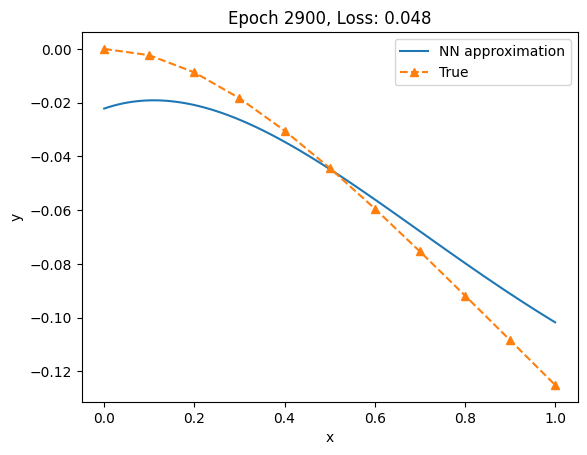

Epoch 2910| Total loss: 0.047, Val loss: 0.000| L0: 0.000, L1: 0.015, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2920| Total loss: 0.047, Val loss: 0.000| L0: 0.000, L1: 0.015, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.020
Epoch 2930| Total loss: 0.047, Val loss: 0.000| L0: 0.000, L1: 0.015, L2: 0.000, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 2940| Total loss: 0.047, Val loss: 0.000| L0: 0.000, L1: 0.014, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 2950| Total loss: 0.046, Val loss: 0.000| L0: 0.000, L1: 0.014, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 2960| Total loss: 0.046, Val loss: 0.000| L0: 0.000, L1: 0.014, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 2970| Total loss: 0.046, Val loss: 0.000| L0: 0.000, L1: 0.014, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 2980| Total loss: 0.045, Val loss: 0.000| L0: 0.000, L1: 0.014, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 2990| Total loss: 0.045, Val loss: 0.000| L0: 0.000, L1: 0.013, L2: 0.001, L3: 0.003, L4: 

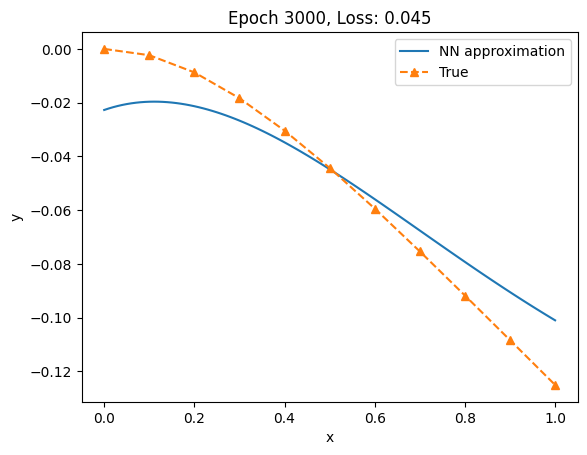

Epoch 3010| Total loss: 0.044, Val loss: 0.000| L0: 0.000, L1: 0.013, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 3020| Total loss: 0.044, Val loss: 0.000| L0: 0.000, L1: 0.013, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 3030| Total loss: 0.044, Val loss: 0.000| L0: 0.000, L1: 0.013, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 3040| Total loss: 0.044, Val loss: 0.000| L0: 0.000, L1: 0.013, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.019
Epoch 3050| Total loss: 0.043, Val loss: 0.000| L0: 0.000, L1: 0.012, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3060| Total loss: 0.043, Val loss: 0.000| L0: 0.000, L1: 0.012, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3070| Total loss: 0.043, Val loss: 0.000| L0: 0.000, L1: 0.012, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3080| Total loss: 0.043, Val loss: 0.000| L0: 0.000, L1: 0.012, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3090| Total loss: 0.042, Val loss: 0.000| L0: 0.000, L1: 0.012, L2: 0.001, L3: 0.003, L4: 

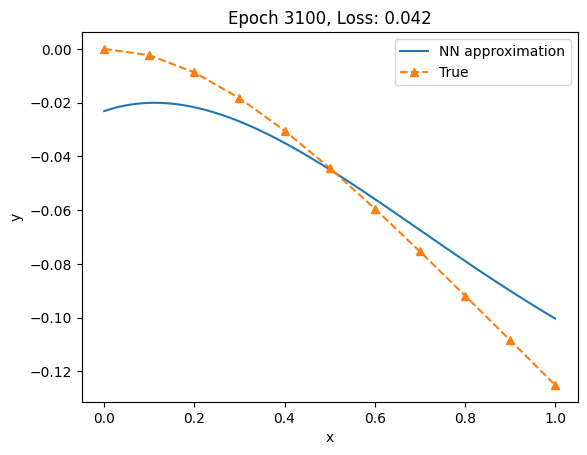

Epoch 3110| Total loss: 0.042, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3120| Total loss: 0.041, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3130| Total loss: 0.041, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3140| Total loss: 0.041, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3150| Total loss: 0.041, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.018
Epoch 3160| Total loss: 0.040, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3170| Total loss: 0.040, Val loss: 0.000| L0: 0.000, L1: 0.011, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3180| Total loss: 0.040, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3190| Total loss: 0.040, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 

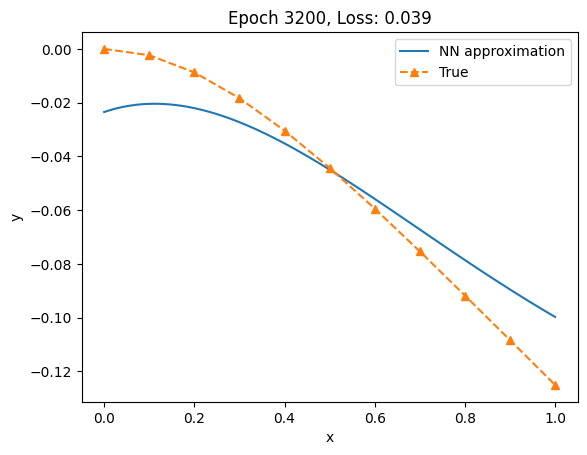

Epoch 3210| Total loss: 0.039, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3220| Total loss: 0.039, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3230| Total loss: 0.039, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3240| Total loss: 0.038, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3250| Total loss: 0.038, Val loss: 0.000| L0: 0.000, L1: 0.010, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3260| Total loss: 0.038, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.017
Epoch 3270| Total loss: 0.038, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.009, L5: 0.016
Epoch 3280| Total loss: 0.038, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3290| Total loss: 0.037, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 

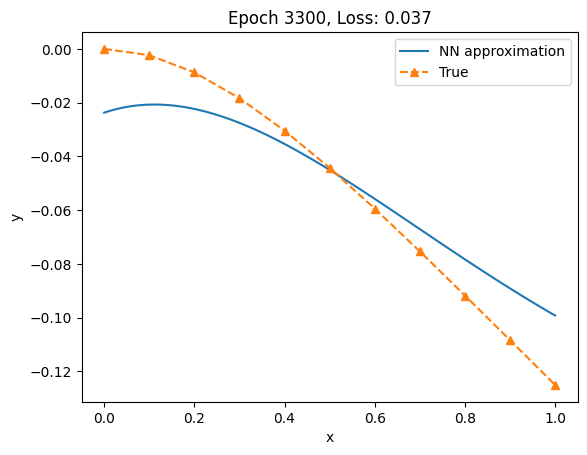

Epoch 3310| Total loss: 0.037, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3320| Total loss: 0.037, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3330| Total loss: 0.036, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3340| Total loss: 0.036, Val loss: 0.000| L0: 0.000, L1: 0.009, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3350| Total loss: 0.036, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3360| Total loss: 0.036, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3370| Total loss: 0.036, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.016
Epoch 3380| Total loss: 0.035, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3390| Total loss: 0.035, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 

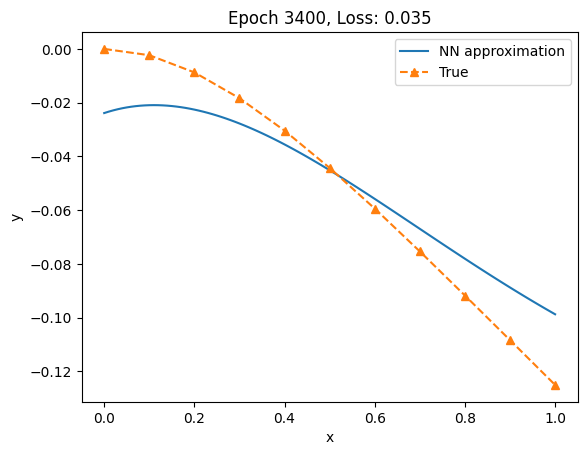

Epoch 3410| Total loss: 0.035, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3420| Total loss: 0.034, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3430| Total loss: 0.034, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3440| Total loss: 0.034, Val loss: 0.000| L0: 0.000, L1: 0.008, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3450| Total loss: 0.034, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3460| Total loss: 0.034, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3470| Total loss: 0.033, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3480| Total loss: 0.033, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.015
Epoch 3490| Total loss: 0.033, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 

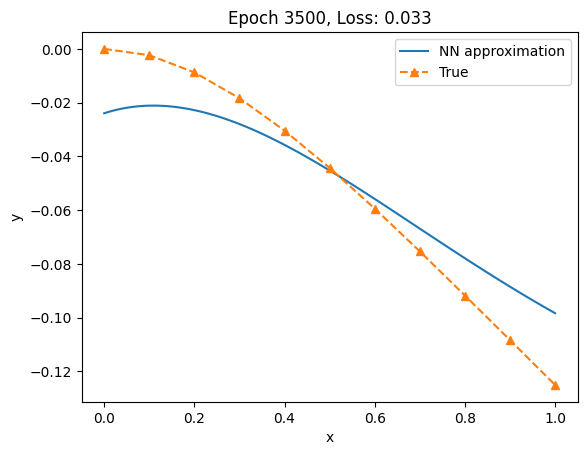

Epoch 3510| Total loss: 0.033, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3520| Total loss: 0.032, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3530| Total loss: 0.032, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3540| Total loss: 0.032, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3550| Total loss: 0.032, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3560| Total loss: 0.032, Val loss: 0.000| L0: 0.000, L1: 0.007, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3570| Total loss: 0.032, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3580| Total loss: 0.031, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.014
Epoch 3590| Total loss: 0.031, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 

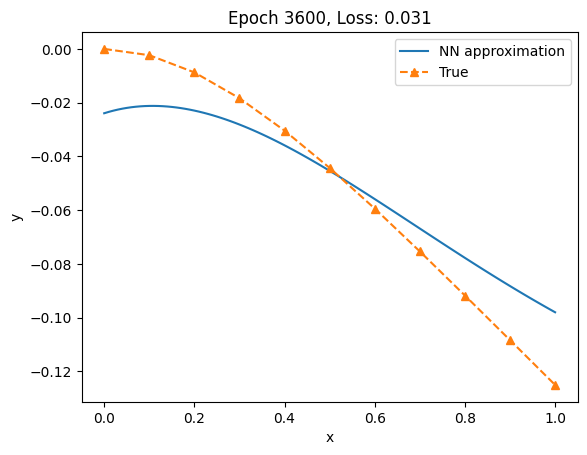

Epoch 3610| Total loss: 0.031, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3620| Total loss: 0.031, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3630| Total loss: 0.030, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3640| Total loss: 0.030, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3650| Total loss: 0.030, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3660| Total loss: 0.030, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3670| Total loss: 0.030, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3680| Total loss: 0.030, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3690| Total loss: 0.029, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 

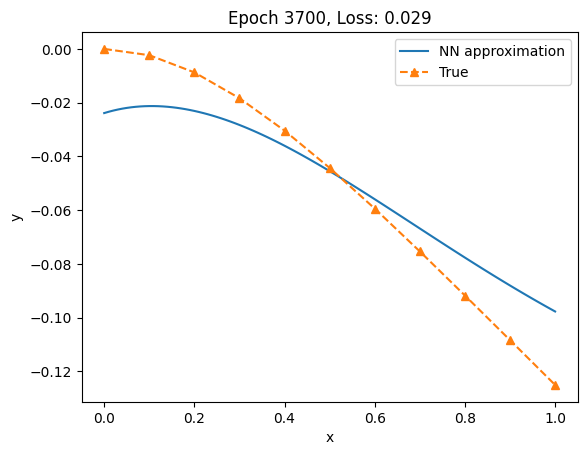

Epoch 3710| Total loss: 0.029, Val loss: 0.000| L0: 0.000, L1: 0.006, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.013
Epoch 3720| Total loss: 0.029, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3730| Total loss: 0.029, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3740| Total loss: 0.029, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3750| Total loss: 0.028, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3760| Total loss: 0.028, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3770| Total loss: 0.028, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3780| Total loss: 0.028, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 0.008, L5: 0.012
Epoch 3790| Total loss: 0.028, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.003, L4: 

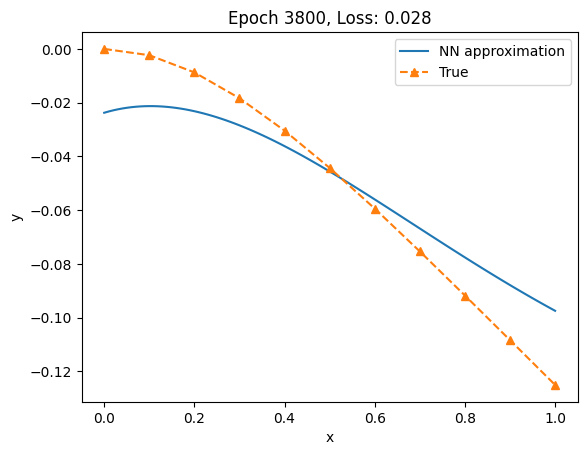

Epoch 3810| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.012
Epoch 3820| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.012
Epoch 3830| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.012
Epoch 3840| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3850| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3860| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3870| Total loss: 0.027, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3880| Total loss: 0.026, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3890| Total loss: 0.026, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 

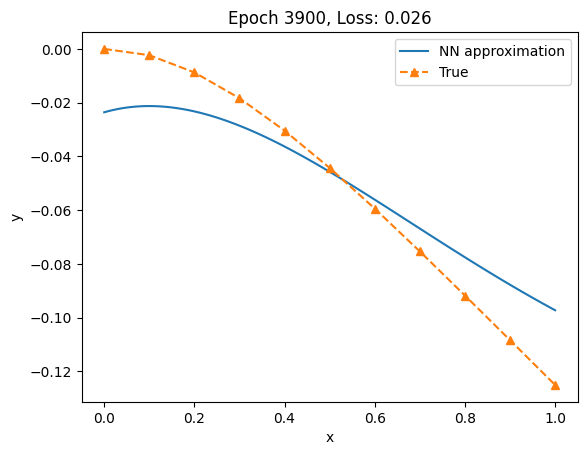

Epoch 3910| Total loss: 0.026, Val loss: 0.000| L0: 0.000, L1: 0.005, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3920| Total loss: 0.026, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3930| Total loss: 0.026, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3940| Total loss: 0.026, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3950| Total loss: 0.025, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.011
Epoch 3960| Total loss: 0.025, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 3970| Total loss: 0.025, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 3980| Total loss: 0.025, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 3990| Total loss: 0.025, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 

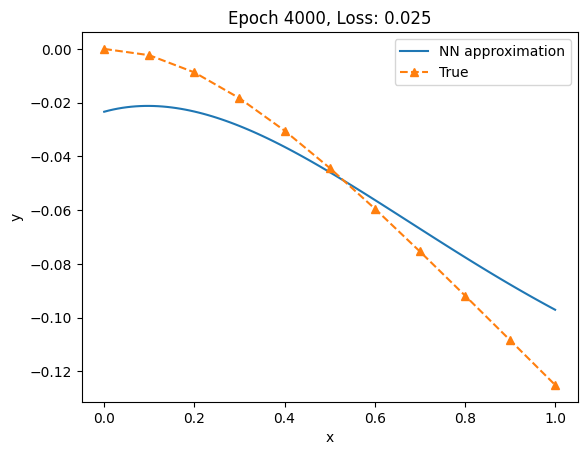

Epoch 4010| Total loss: 0.025, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4020| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4030| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4040| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4050| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4060| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4070| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4080| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.010
Epoch 4090| Total loss: 0.024, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 

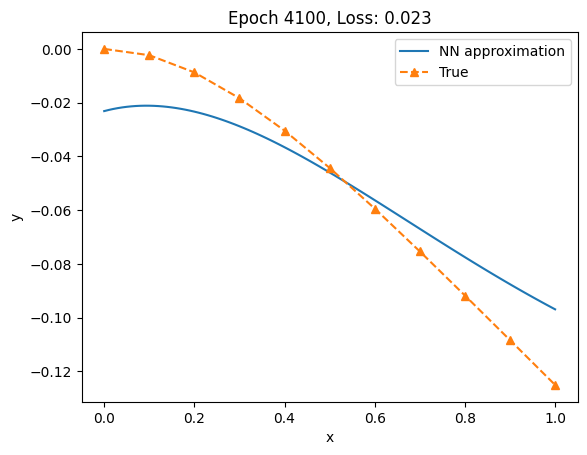

Epoch 4110| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4120| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4130| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4140| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4150| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4160| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4170| Total loss: 0.023, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4180| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4190| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 

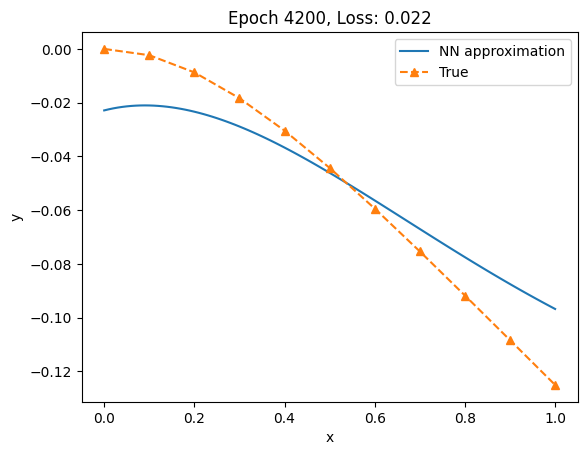

Epoch 4210| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.004, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4220| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.009
Epoch 4230| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4240| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4250| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4260| Total loss: 0.022, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4270| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4280| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4290| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 

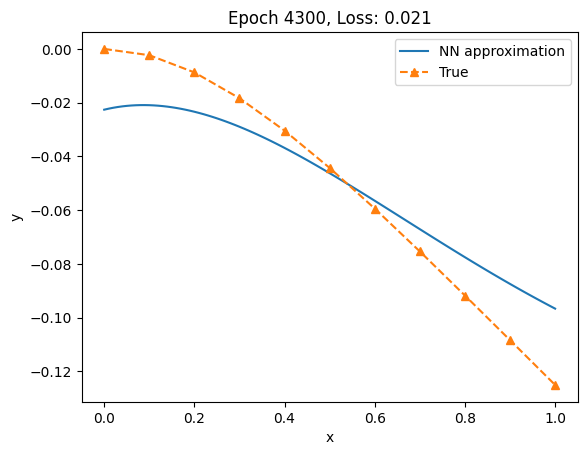

Epoch 4310| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4320| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4330| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4340| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4350| Total loss: 0.021, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4360| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.008
Epoch 4370| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.007
Epoch 4380| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 0.008, L5: 0.007
Epoch 4390| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.001, L3: 0.002, L4: 

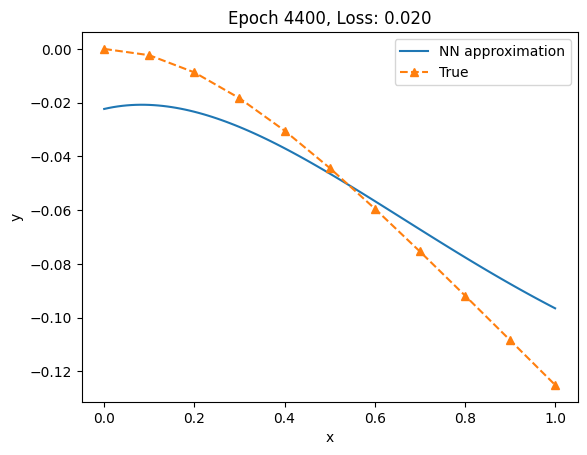

Epoch 4410| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4420| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4430| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4440| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4450| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4460| Total loss: 0.020, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4470| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4480| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4490| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 

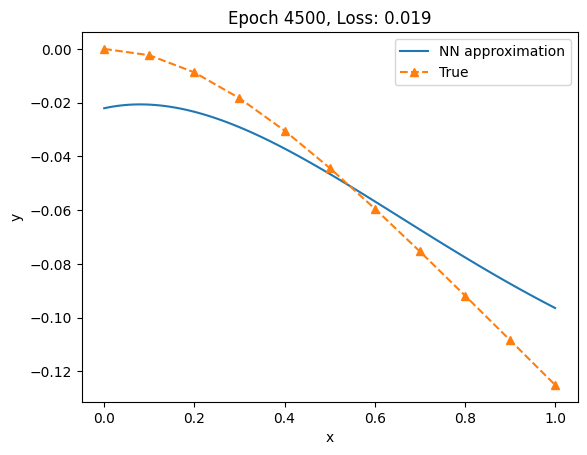

Epoch 4510| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4520| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.007
Epoch 4530| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4540| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4550| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4560| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4570| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4580| Total loss: 0.019, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4590| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 

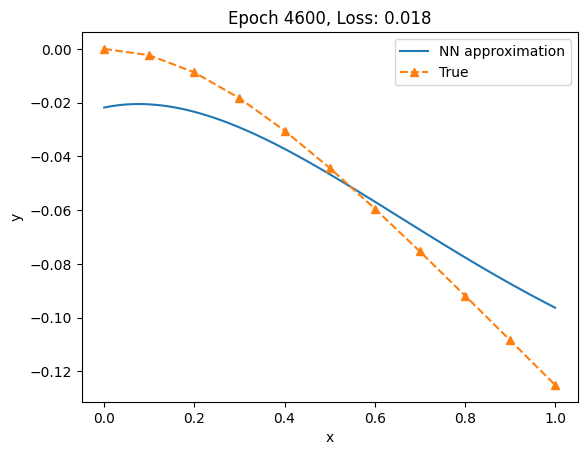

Epoch 4610| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4620| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4630| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4640| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4650| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4660| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4670| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4680| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.006
Epoch 4690| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 

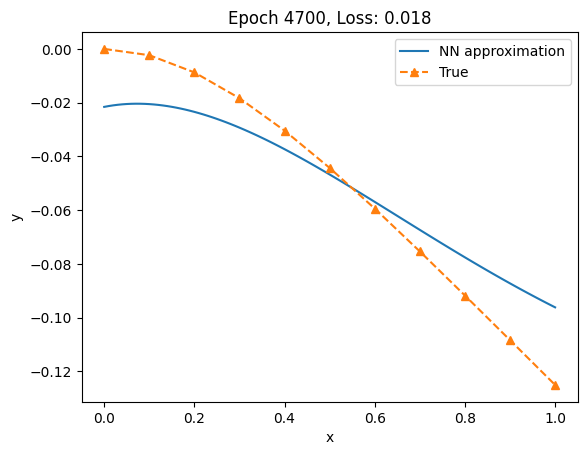

Epoch 4710| Total loss: 0.018, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4720| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4730| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4740| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4750| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4760| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4770| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4780| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4790| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 

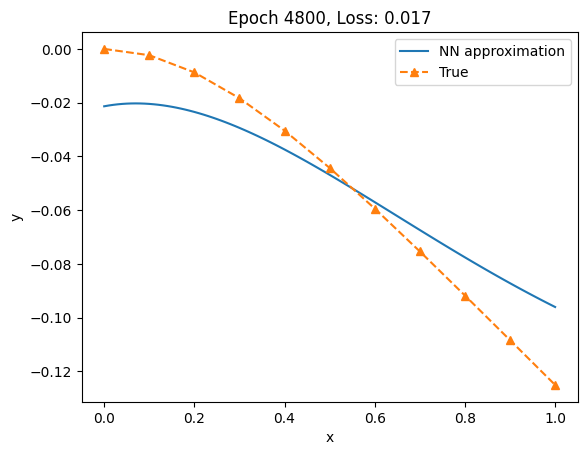

Epoch 4810| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4820| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4830| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4840| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4850| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4860| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4870| Total loss: 0.017, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4880| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.005
Epoch 4890| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 

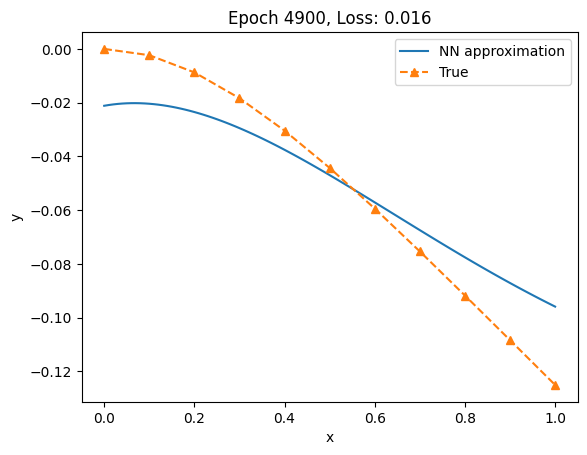

Epoch 4910| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4920| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4930| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4940| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4950| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4960| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4970| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4980| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 0.008, L5: 0.004
Epoch 4990| Total loss: 0.016, Val loss: 0.000| L0: 0.000, L1: 0.003, L2: 0.000, L3: 0.001, L4: 

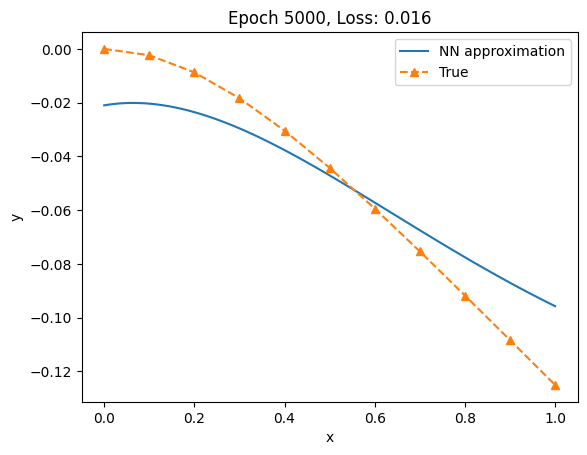

Training completed. Best validation loss was 0.000 at epoch 1226


In [11]:
set_random_seed(seed)

# Training the model
epochs = 5000
initial_lr = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

total_losses = []
validation_losses = []  # 검증 손실을 저장할 리스트
indiv_losses = []
lr = initial_lr
patience = 50
min_delta = 0.0001
reduce_factor = 0.5

best_loss = float('inf')
best_epoch = 0
losses_to_check = []
checkpoint_path = "best_model_lab3.ckpt"

for epoch in range(epochs):
    with tf.GradientTape(persistent=True) as tape:
        # y_pred = model(x_train_tensor)
        
        y, dy_dx, d2y_dx2, d3y_dx3, d4y_dx4 = compute_derivatives(x_train_tensor, model)

        # 0. collocation point loss
        loss_cp = tf.reduce_mean(tf.square(y-y_true))
        
        # 1. governing loss
        f_x = d4y_dx4 + 1
        loss_ge = tf.reduce_mean(tf.square(f_x))
        
        # 2. boundary condition loss
        loss_u_0 = tf.reduce_mean(tf.square(y[0]-x_boundary_tensor[0]))
        loss_dudt_0 = tf.reduce_mean(tf.square(dy_dx[0]-x_boundary_tensor[1]))
        loss_d2udt2_1 = tf.reduce_mean(tf.square(d2y_dx2[-1]-x_boundary_tensor[2]))
        loss_d3udt3_1 = tf.reduce_mean(tf.square(d3y_dx3[-1]-x_boundary_tensor[3]))

        loss_bc = loss_dudt_0 + loss_d2udt2_1 + loss_d3udt3_1 # loss_u_0 + : collocation point loss 내부에 존재. 
        
        total_loss = loss_cp + loss_ge + loss_bc # loss_cp
        

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # 검증
    x_val_tensor = x_train_tensor
    y_val_true = y_true
    with tf.GradientTape() as val_tape:
        val_y_pred = model(x_val_tensor)
        validation_loss = tf.reduce_mean(tf.square(val_y_pred - y_val_true))
    validation_losses.append(validation_loss.numpy())

    if validation_loss < best_loss:
        best_loss = validation_loss
        best_epoch = epoch
        model.save_weights(checkpoint_path)  # 현재 모델의 가중치를 저장합니다.

    # Loss 저장
    indiv_losses.append([loss_cp, loss_ge, loss_u_0, loss_dudt_0, loss_d2udt2_1, loss_d3udt3_1])
    total_losses.append(total_loss.numpy())
    losses_to_check.append(total_loss.numpy())

    if len(losses_to_check) > patience:
        loss_reduction = (losses_to_check[-patience] - losses_to_check[-1]) / losses_to_check[-patience]
        if loss_reduction < min_delta:
            lr *= reduce_factor
            optimizer.learning_rate.assign(lr)
            print(f"Learning rate reduced to {lr:.6f} at epoch {epoch+1}")
        losses_to_check.pop(0)  # Remove the oldest loss

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:4d}| Total loss: {total_loss.numpy():4.3f}, Val loss: {validation_loss.numpy():4.3f}| L0: {loss_cp:2.3f}, L1: {loss_ge:2.3f}, L2: {loss_u_0:2.3f}, L3: {loss_dudt_0:2.3f}, L4: {loss_d2udt2_1:2.3f}, L5: {loss_d3udt3_1:.3f}")
    
    if (epoch+1) % 100 == 0:
        x_test = np.linspace(0, 1, num=101).reshape(-1, 1).astype(np.float32)
        y_test = model.predict(x_test)
        plt.title(f'Epoch {epoch+1}, Loss: {total_loss.numpy():.3f}')
        plt.plot(x_test, y_test, label='NN approximation')
        plt.plot(x_train1, y_train1_true, '^--', label='True')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()
        plt.close()

print(f"Training completed. Best validation loss was {best_loss:.3f} at epoch {best_epoch+1}")

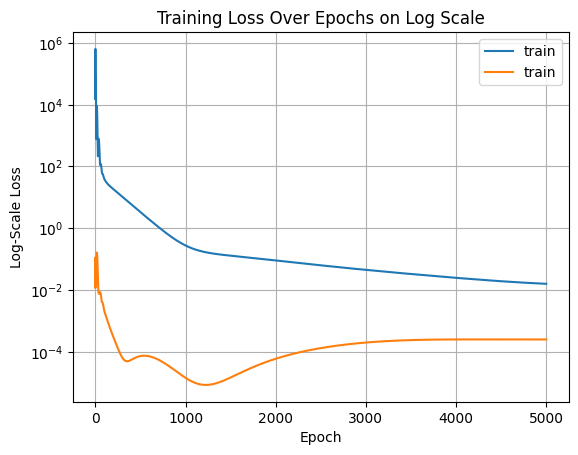

In [12]:
plt.figure()
plt.plot(range(epochs), total_losses, label='train')
plt.plot(range(epochs), validation_losses, label='train')
plt.yscale('log')  # Set the y-axis to log scale with base 10
plt.xlabel('Epoch')
plt.ylabel('Log-Scale Loss')
plt.title('Training Loss Over Epochs on Log Scale')
plt.legend()
plt.grid()
plt.show()

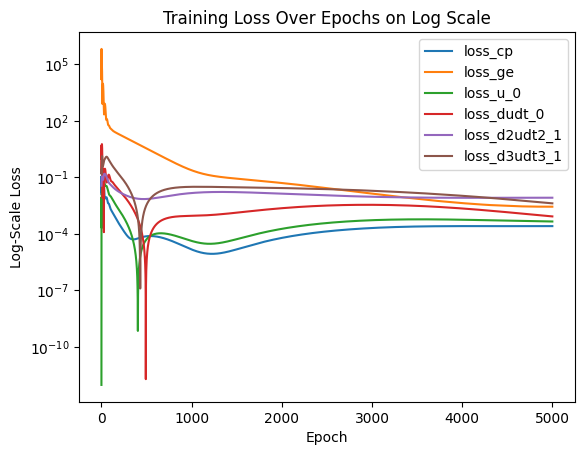

In [13]:
indiv_losses_label = ['loss_cp', 'loss_ge','loss_u_0','loss_dudt_0','loss_d2udt2_1','loss_d3udt3_1']
plt.figure()
for i in range(np.shape(indiv_losses)[1]):
    plt.plot(range(epochs), np.array(indiv_losses)[:,i], label = indiv_losses_label[i])

plt.legend()
plt.yscale('log')  # Set the y-axis to log scale with base 10
plt.xlabel('Epoch')
plt.ylabel('Log-Scale Loss')
plt.title('Training Loss Over Epochs on Log Scale')
plt.show()
plt.close()

In [14]:
model.load_weights(checkpoint_path)

4/4 [==============================] - 0s 1ms/step


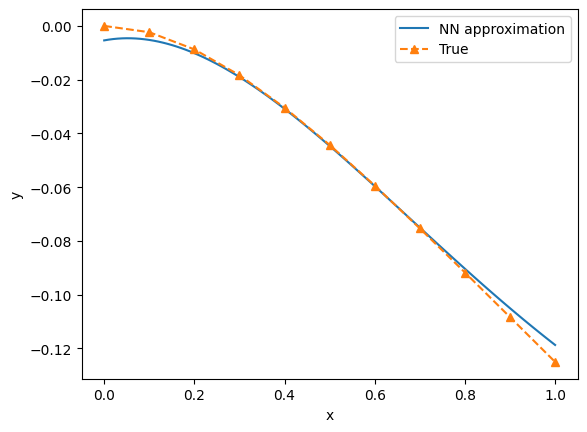

In [15]:
# Plot the results
x_test = np.linspace(0, 1, num=101).reshape(-1, 1).astype(np.float32)
y_test = model.predict(x_test)

plt.plot(x_test, y_test, label='NN approximation')
plt.plot(x_train1, y_train1_true, '^--', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

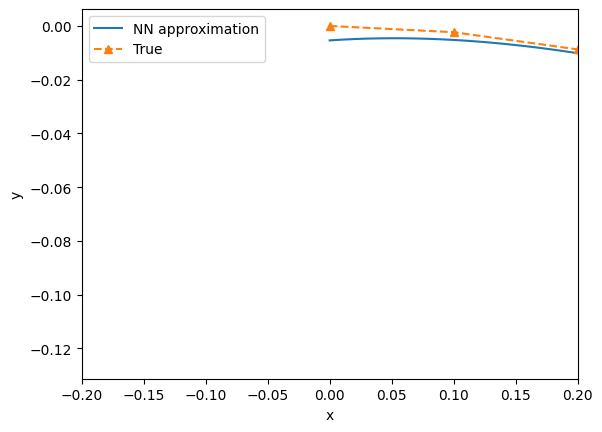

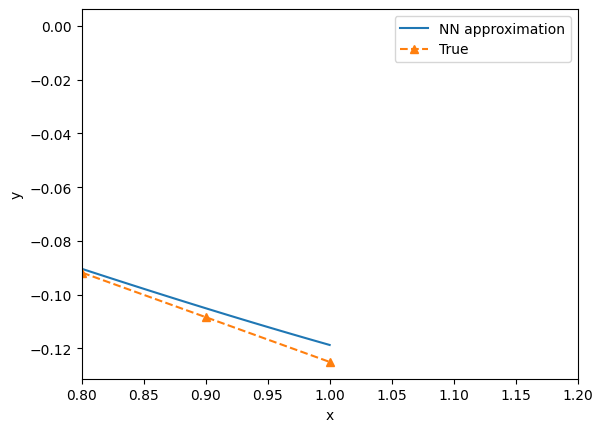

In [16]:
plt.figure()
plt.plot(x_test, y_test, label='NN approximation')
plt.plot(x_train1, y_train1_true, '^--', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.xlim([-0.2, 0.2]) # 1-0.2,1
plt.show()

plt.figure()
plt.plot(x_test, y_test, label='NN approximation')
plt.plot(x_train1, y_train1_true, '^--', label='True')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.xlim([0.8,1.2]) # 1-0.2,1
plt.show()
plt.close()

In [17]:
print(dy_dx)
print(d2y_dx2)
print(d3y_dx3)
print(d4y_dx4)

tf.Tensor(
[[ 0.02862253]
 [-0.01429677]
 [-0.04748061]
 [-0.07190323]
 [-0.08859664]
 [-0.0985485 ]
 [-0.10277604]
 [-0.1023182 ]
 [-0.09815388]
 [-0.09129258]
 [-0.08279727]], shape=(11, 1), dtype=float32)
tf.Tensor(
[[-0.48228553]
 [-0.37869418]
 [-0.2863896 ]
 [-0.20386764]
 [-0.13160828]
 [-0.06912884]
 [-0.01717551]
 [ 0.02472723]
 [ 0.05688232]
 [ 0.07854185]
 [ 0.08970784]], shape=(11, 1), dtype=float32)
tf.Tensor(
[[1.1122559 ]
 [0.96605194]
 [0.8786917 ]
 [0.7715583 ]
 [0.6748841 ]
 [0.57265794]
 [0.46769655]
 [0.37105143]
 [0.2703688 ]
 [0.16267034]
 [0.06363755]], shape=(11, 1), dtype=float32)
tf.Tensor(
[[-1.0068188 ]
 [-1.0002365 ]
 [-1.0042038 ]
 [-1.0304146 ]
 [-0.9592171 ]
 [-1.0723495 ]
 [-1.0010262 ]
 [-0.9618771 ]
 [-1.0576541 ]
 [-1.0658383 ]
 [-0.88786435]], shape=(11, 1), dtype=float32)


In [18]:
# def compute_derivatives(x, model):
#     with tf.GradientTape(persistent=True) as tape4:
#         with tf.GradientTape(persistent=True) as tape3:
#             with tf.GradientTape(persistent=True) as tape2:
#                 with tf.GradientTape(persistent=True) as tape1:
#                     tape1.watch(x)
#                     tape2.watch(x)
#                     tape3.watch(x)
#                     tape4.watch(x)
#                     # true_solution 함수를 호출하여 y 값을 설정
#                     # y = true_solution(x)
#                     y = model(x)
                    
#                 dy_dx = tape1.gradient(y, x)
#                 tape2.watch(dy_dx)
#             d2y_dx2 = tape2.gradient(dy_dx, x)
#             tape3.watch(d2y_dx2)
#         d3y_dx3 = tape3.gradient(d2y_dx2, x)
#         tape4.watch(d3y_dx3)
#     d4y_dx4 = tape4.gradient(d3y_dx3, x)

#     del tape1, tape2, tape3, tape4  # 모든 tape를 삭제
#     return dy_dx, d2y_dx2, d3y_dx3, d4y_dx4

# compute_derivatives(x_train_tensor, true_solution)